# Summary
<br>
Code based on https://arxiv.org/abs/1902.09833 
<br> Simulating a cavity, emmiting to a two level system, emmiting a photon into a cavity using qutip.
<br>

---

In [21]:
import qutip
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import erf
#from scipy import constants as const

In [44]:
#Number of fock states in the inputoutput cavity
N_u = 2
N_v = 2

#Coupling constant         
mu = 3
sigma = 0.8
gamma = 0.2

In [45]:

#Defining the shape of the output pulse as a function of time
def v(t,args=None):
    b = (t-mu+(0.5*gamma*sigma*sigma))/(sigma*np.sqrt(2))
    term = (erf(-1*b)+1) * np.exp(b**2) * 0.5 * gamma * np.sqrt(np.pi**0.5)
    term_2 = (1 - term) * u(t,None)
  #return 4*np.exp(-0.5*16*(t-5)**2)/(2*np.pi)**0.5
    #return 0.5 + (np.arctan(5*(-t))/np.pi)
    return term_2
    #return 10
    #return np.sqrt(gamma)*np.exp(-t*gamma/2)
#*np.heaviside()

#Defining |v(t)|^2 
def v_2(t):
    return np.conj(v(t))*v(t)

#Defining the time dependent coupling
def g_v(t, args):
    integral = quad(v_2, 0, t)[0]
    #return -np.conj(v(t))/ ( integral**0.5 )
  #return -1*np.conj(v(t))/ ( 1 - np.exp(-t*gamma) )**0.5
  #return (-1/( np.exp(t*gamma) - 1 )**0.5)
    return 0

###########################################
    
def u(t,args=None):
    #gauss = np.exp(-0.5*( (t-mu)/sigma )**2)/(sigma*(2*np.pi)**0.5)
    gauss = np.exp(-0.5*( (t-mu)/sigma )**2)/(np.pi**0.25)
    #return np.sqrt(gamma)*np.exp(-t*gamma/2)
    return gauss

#Defining |u(t)|^2 
def u_2(t):
    return np.conj(u(t))*u(t)
    


#Defining the time dependent coupling
def g_u(t, args):
    integral = quad(u_2, 0, t)[0]
    return np.conj(u(t))/ (1-integral)**0.5 
    #return 0

def g_uv(t,args):
    return g_u(t,None)*g_v(t,None)


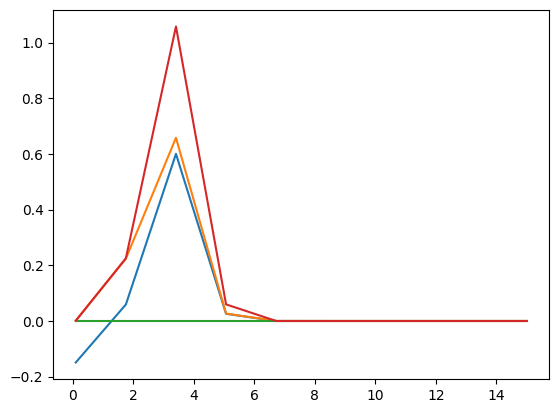

In [46]:

t_no = 10

#Plotting out the output pulse and time dependent coupling
times = np.linspace(0.1, 15, t_no)

plt.plot(times, [v(t) for t in times]) 
plt.plot(times, [u(t) for t in times]) 
plt.plot(times, [g_v(t, None) for t in times]) 
plt.plot(times, [g_u(t, None) for t in times]) 


In [47]:

#Defining initial state of the system and cavity, with the system in excited state 
psi0 = qutip.tensor(qutip.fock(N_u, 1), qutip.fock(2,0), qutip.fock(N_v, 0))

#Anihilation operator of the cavity
a_u  = qutip.tensor(qutip.destroy(N_u), qutip.qeye(2), qutip.qeye(N_v))
a_v  = qutip.tensor(qutip.qeye(N_u), qutip.qeye(2), qutip.destroy(N_v))

#Lowering operator of the system
c = qutip.tensor(qutip.qeye(N_u), qutip.destroy(2), qutip.qeye(N_v))

H = [ c.dag()*c , [ 0.5j*(gamma**0.5)*( (c.dag()*a_v)-(a_v.dag()*c) ) , g_v], [  0.5j*(gamma**0.5)*( (a_u.dag()*c)-(c.dag()*a_u) ) ,g_u], [0.5j*((a_u.dag()*a_v)- (a_v.dag()*a_u)) ,g_uv]]                     #Net time dependent Hamiltonian (Eq 5 in the Quantum Pulses paper)

L_0 = [ (gamma**0.5)*c, [a_v, g_v], [a_u, g_u]]                                                #Lindblad operator 0 (Eq 6)
L_0dag = [ (gamma**0.5)*c.dag(), [a_v.dag(), g_v], [a_u.dag(), g_u]]

I = qutip.tensor(qutip.qeye(N_u), qutip.qeye(2), qutip.qeye(N_v))

result = qutip.mesolve(H, psi0, times, [L_0], [a_u.dag()*a_u, c.dag()*c, a_v.dag()*a_v])            #Evolving the system , with output c*c and a*a


In [48]:
result_states = qutip.mesolve(H, psi0, times, [L_0,], [])            #Evolving the system , with output of rho's at various times
I_0 = list()
for q in range(t_no):
    L_0t = ( (gamma**0.5)*c + a_v*g_v(times[q], None) + a_u*g_u(times[q], None)) 
    I_0.append( (L_0t.dag() * L_0t * result_states.states[q]).tr() )

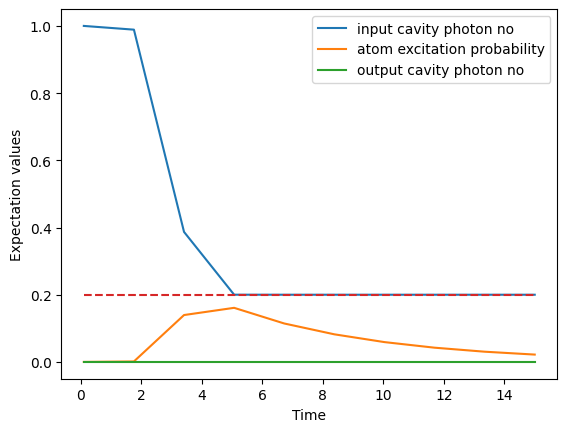

0.2

In [49]:
plt.figure() 
plt.plot(times, result.expect[0]) 
plt.plot(times, result.expect[1]) 
plt.plot(times, result.expect[2]) 
#plt.plot(times, result.expect[1]+result.expect[2]) 
#plt.plot(times, (np.cumsum(I_0)-I_0[0])*(times[1]-times[0]) )

plt.plot([times[0], times[-1]], [result.expect[0][-1], result.expect[0][-1]],'--') 
#plt.plot([times[0], times[-1]], [result.expect[1][-1], result.expect[1][-1]],'--')
#plt.plot(times, (np.cumsum(I_0)-I_0[0])*(times[1]-times[0]) )
#plt.plot(times, (np.cumsum(I_0)-I_0[0])*(times[1]-times[0]) + result.expect[1] , 'b')
#plt.plot(times, result.expect[2]) 
#plt.plot(times, result.expect[3]) 

plt.xlabel('Time') 
plt.ylabel('Expectation values') 
plt.legend(("input cavity photon no", "atom excitation probability", "output cavity photon no")) 
plt.show() 
gamma

In [50]:
((np.cumsum(I_0)-I_0[0])*(times[1]-times[0]) + result.expect[1])[-1]

(0.7702140469270591+4.512247756146114e-17j)

In [29]:
I

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]

In [13]:
qutip.correlation_2op_2t(H, psi0, [0,0.1], [0,0.2], [L_0], I , I )

array([[1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j]])

In [14]:
qutip.correlation_2op_2t(H, psi0, [0,0.2], [0,0.3], [L_0], c , c )[1][1]

0j

In [ ]:
t_tau_corel = 

In [51]:
times[0] = 0
corel = np.zeros(shape=(t_no,t_no))          #t' , tau

for i in range(t_no):
    for j in range(t_no):
        # i is t' , j is tau
        t_ = times[i]
        t = times[j] + t_
        A =  (gamma**0.5)*c.dag() + (a_u.dag()*g_u(t,None))
        B =  (gamma**0.5)*c + (a_u*g_u(t_,None))
        corel[i][j] = qutip.correlation_2op_2t(H, psi0, [0,t_], [0,(t-t_)], [L_0], A , B )[1][1]
        print(i)



/var/folders/s9/whvhj6gs5cx001kw71n2wfqr0000gq/T/ipykernel_54264/272441443.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  corel[i][j] = qutip.correlation_2op_2t(H, psi0, [0,t_], [0,(t-t_)], [L_0], A , B )[1][1]


0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5


/var/folders/s9/whvhj6gs5cx001kw71n2wfqr0000gq/T/ipykernel_54264/4112932328.py:4: RuntimeWarning: overflow encountered in exp
  term = (erf(-1*b)+1) * np.exp(b**2) * 0.5 * gamma * np.sqrt(np.pi**0.5)
/var/folders/s9/whvhj6gs5cx001kw71n2wfqr0000gq/T/ipykernel_54264/4112932328.py:4: RuntimeWarning: invalid value encountered in scalar multiply
  term = (erf(-1*b)+1) * np.exp(b**2) * 0.5 * gamma * np.sqrt(np.pi**0.5)
/var/folders/s9/whvhj6gs5cx001kw71n2wfqr0000gq/T/ipykernel_54264/4112932328.py:19: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = quad(v_2, 0, t)[0]


5
5
5
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9


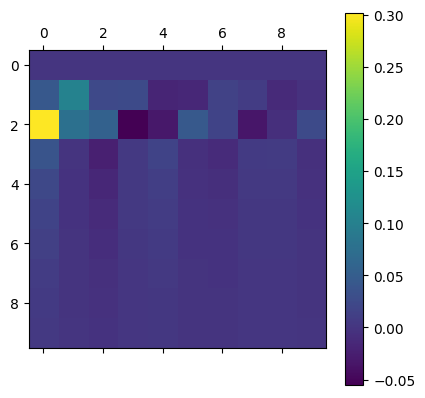

In [52]:
plt.matshow(corel)
plt.colorbar()
#plotting v(t) vs v(tau)

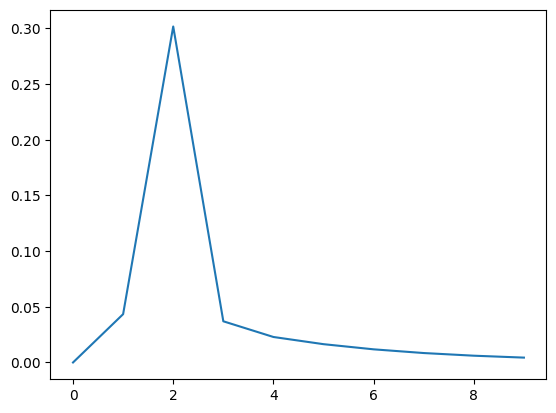

In [53]:
plt.plot(np.real(corel).T[0])


In [19]:
correlation[0][0]/gamma

NameError: name 'correlation' is not defined

In [ ]:
plt.plot(np.real(correlation.T)[0]/np.real(correlation[0])[0], 'r')
plt.plot(range(t), [np.exp(-times[x]*gamma) for x in range(t)], '.')
plt.legend(("v(2t)", "fitted function")) 

In [ ]:
plt.plot(np.real(correlation)[0]/np.real(correlation[0])[0], 'r')
plt.plot(range(t), [np.exp(-times[x]*gamma/2) for x in range(t)], '.')
plt.legend(("v(tau)", "fitted function")) 

In [ ]:
t = np.linspace(0,10,101)
plt.plot(t,4*np.exp(-0.5*16*(t-5)**2)/(2*np.pi)**0.5)
plt.plot(t, np.sqrt(gamma)*np.exp(-gamma/2*t))

In [ ]:
plt.plot(times, [0.5 + (np.arctan(5*(10-x))/np.pi) for x in times]) 

In [ ]:
g = 0.3
n = 100
times = np.linspace(0, 20, n)

#testing out the propogator 
rx, ry, rz = [2,1,-1]
norm = (rx**2 + ry**2 + rz**2 )**0.5 
rx = rx/norm
ry = ry/norm
rz = rz/norm

rho_0 = 0.5*(qutip.qeye(2) + (rz*qutip.sigmaz()) + (ry*qutip.sigmay()) + (rx*qutip.sigmax()))
#qutip.fock(2,1).full()

d = qutip.destroy(2)

#result = qutip.mesolve(qutip.qeye(2), rho_0, times, [(g**0.5)*d], [d,])         # H, rho(0), times, collapse op, obserbables

In [ ]:
plt.matshow( (np.real(correlation)/np.real(correlation[0][0])) - np.real(correlation_2) )
plt.colorbar()